In [ ]:
# 1. Load the "autoreload" extension
%load_ext autoreload

# 2. Set it to mode "2" (Reload everything before executing code)
%autoreload 2

import sys
import os

# 3. Add the project root to the system path
# This allows the notebook to "see" the 'src' folder which is one level up
sys.path.append(os.path.abspath('..'))

# Now you can import your script
from src.data_ingestion import DataIngestion

In [2]:
# notebooks/eda.ipynb

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Adjust pandas display options to see more columns
pd.set_option('display.max_columns', None)

# Load the data
# We use '..' to go up from 'notebooks' folder to root, then down to 'data'
DATA_PATH = '../data/interim/match_data.csv'

try:
    df = pd.read_csv(DATA_PATH)
    print(f"✅ Data Loaded Successfully! Shape: {df.shape}")
    
    # Convert date to datetime immediately
    df['date'] = pd.to_datetime(df['date'])
    
except FileNotFoundError:
    print(f"❌ Error: File not found at {DATA_PATH}")
    print("Check: Are you running this notebook from the 'notebooks/' folder?")

✅ Data Loaded Successfully! Shape: (278205, 17)


In [3]:
# Create a Match-Level Summary Table
match_df = df.groupby(['match_id', 'innings', 'venue', 'batting_team', 'bowling_team']).agg(
    final_score=('total_runs', 'sum'),
    wickets=('is_wicket', 'sum'),
    legal_balls=('is_legal', 'sum'),
    extras=('extras', 'sum')
).reset_index()

# Filter: Only keep standard T20 matches (approx 120 balls) to remove rain-shortened games
match_df = match_df[match_df['legal_balls'] > 60]

print(f"Analyzable Innings: {match_df.shape[0]}")
match_df.head()

Analyzable Innings: 2302


,match_id,innings,venue,batting_team,bowling_team,final_score,wickets,legal_balls,extras
0,335982,1,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,222,3,120,17
1,335982,2,M Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,82,10,91,19
2,335983,1,"Punjab Cricket Association Stadium, Mohali",Chennai Super Kings,Kings XI Punjab,240,5,120,6
3,335983,2,"Punjab Cricket Association Stadium, Mohali",Kings XI Punjab,Chennai Super Kings,207,4,120,11
4,335984,1,Feroz Shah Kotla,Rajasthan Royals,Delhi Daredevils,129,8,120,7


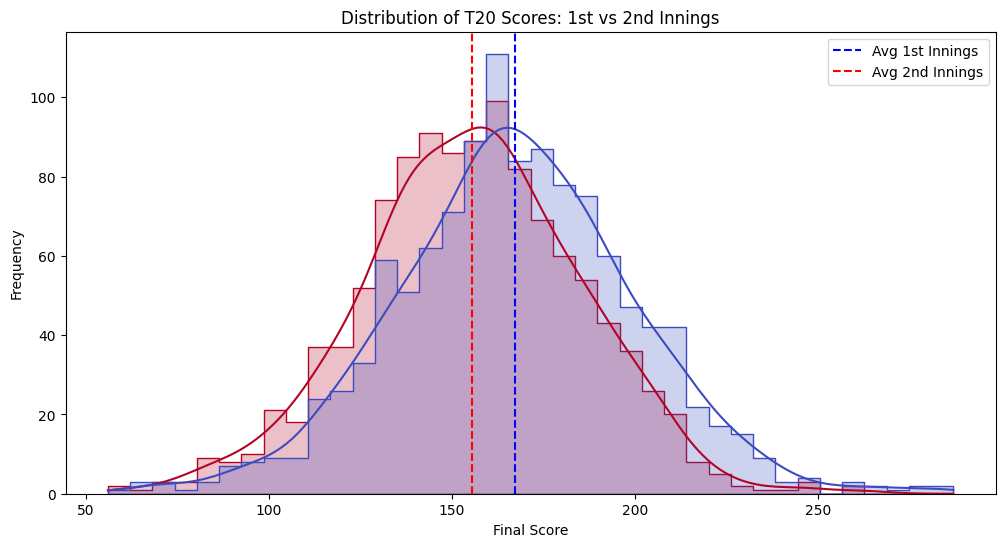

In [4]:
plt.figure(figsize=(12, 6))
sns.histplot(data=match_df, x='final_score', hue='innings', kde=True, palette='coolwarm', element="step")
plt.title('Distribution of T20 Scores: 1st vs 2nd Innings')
plt.xlabel('Final Score')
plt.ylabel('Frequency')
plt.axvline(match_df[match_df['innings']==1]['final_score'].mean(), color='blue', linestyle='--', label='Avg 1st Innings')
plt.axvline(match_df[match_df['innings']==2]['final_score'].mean(), color='red', linestyle='--', label='Avg 2nd Innings')
plt.legend()
plt.show()

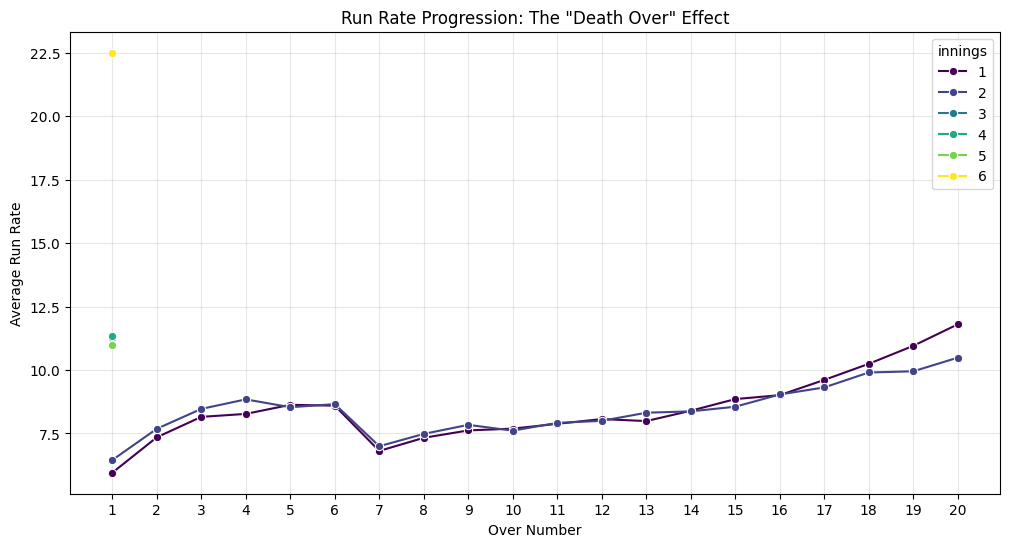

In [5]:
# Group by Over to see average run rate
over_stats = df.groupby(['innings', 'over']).agg(
    runs=('total_runs', 'sum'),
    legal_balls=('is_legal', 'sum')
).reset_index()

# Calculate Run Rate (Runs / Legal Overs)
over_stats['run_rate'] = (over_stats['runs'] / over_stats['legal_balls']) * 6

plt.figure(figsize=(12, 6))
sns.lineplot(data=over_stats, x='over', y='run_rate', hue='innings', marker='o', palette='viridis')
plt.title('Run Rate Progression: The "Death Over" Effect')
plt.xlabel('Over Number')
plt.ylabel('Average Run Rate')
plt.xticks(range(1, 21))
plt.grid(True, alpha=0.3)
plt.show()

/var/folders/n0/5m_fhb1d7xdbhfkz54jbzbnh0000gn/T/ipykernel_93364/897097387.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=venue_stats, y='venue', x='final_score', palette='magma')


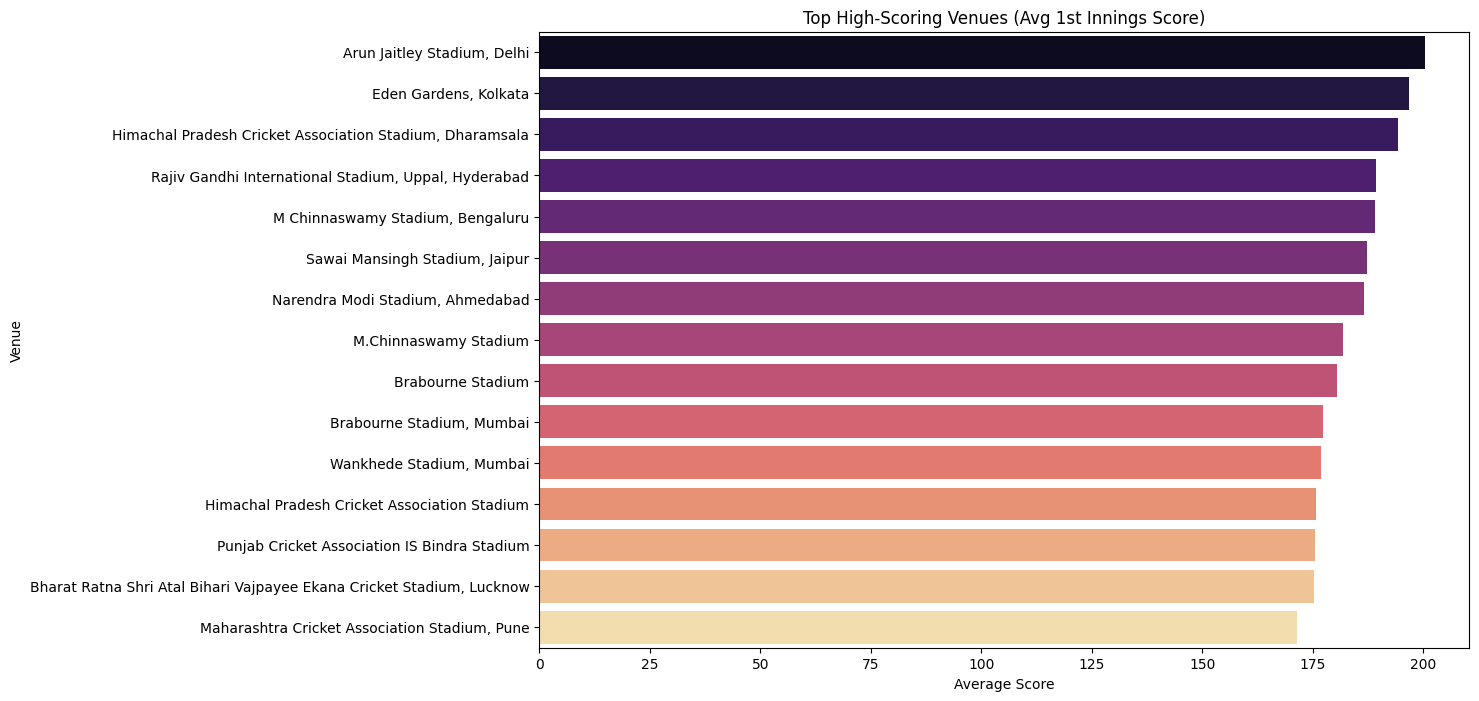

In [6]:
# Calculate average 1st innings score per venue
venue_stats = match_df[match_df['innings'] == 1].groupby('venue')['final_score'].mean().sort_values(ascending=False).reset_index()

# Filter: Only show venues with at least 10 matches played (to remove noise)
venue_counts = match_df['venue'].value_counts()
popular_venues = venue_counts[venue_counts > 10].index
venue_stats = venue_stats[venue_stats['venue'].isin(popular_venues)].head(15) # Top 15 scoring grounds

plt.figure(figsize=(12, 8))
sns.barplot(data=venue_stats, y='venue', x='final_score', palette='magma')
plt.title('Top High-Scoring Venues (Avg 1st Innings Score)')
plt.xlabel('Average Score')
plt.ylabel('Venue')
plt.show()

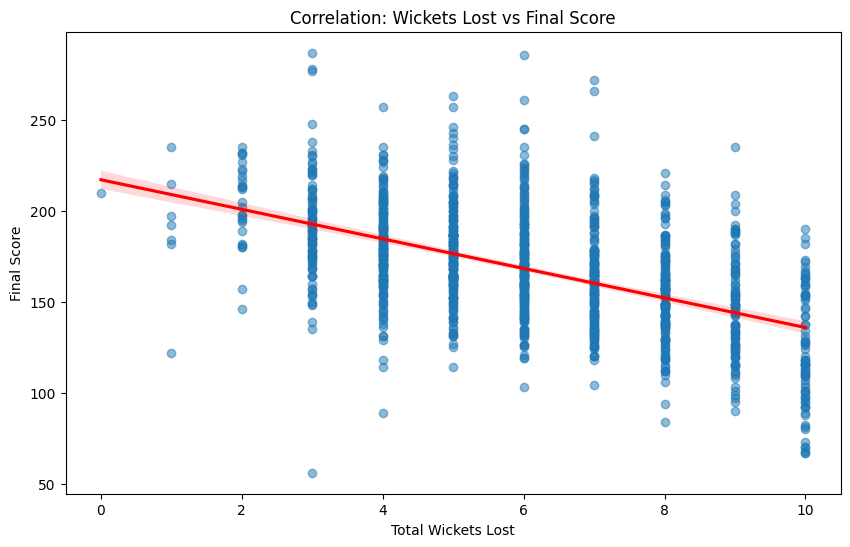

In [7]:
plt.figure(figsize=(10, 6))
# Plotting only 1st innings to see the full potential of teams
sns.regplot(data=match_df[match_df['innings']==1], x='wickets', y='final_score', 
            scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('Correlation: Wickets Lost vs Final Score')
plt.xlabel('Total Wickets Lost')
plt.ylabel('Final Score')
plt.show()

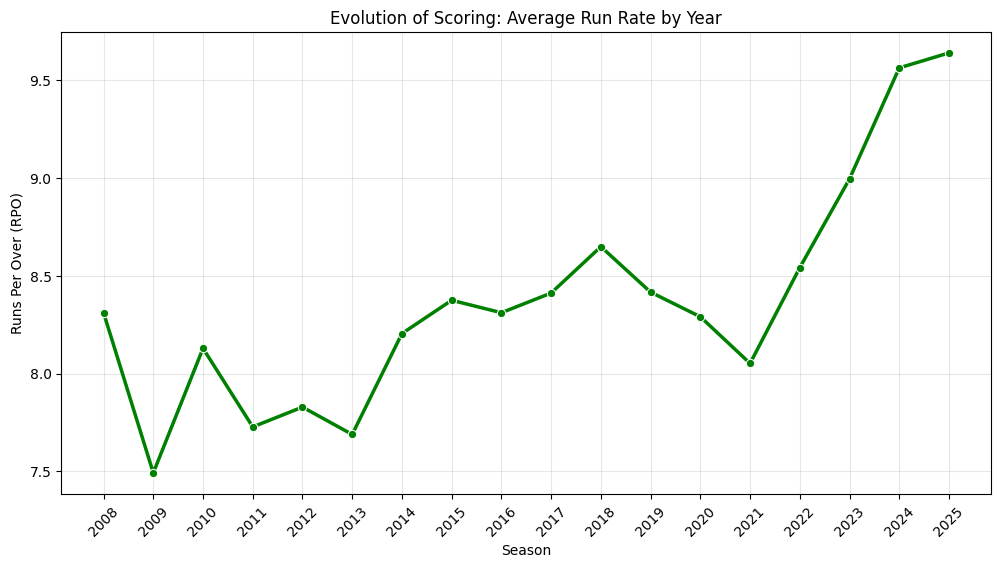

In [8]:
# Extract Year from Date
df['year'] = df['date'].dt.year

# Aggregate by Year
yearly_stats = df.groupby('year').agg(
    total_runs=('total_runs', 'sum'),
    legal_balls=('is_legal', 'sum')
).reset_index()

# Calculate Run Rate
yearly_stats['run_rate'] = (yearly_stats['total_runs'] / yearly_stats['legal_balls']) * 6

plt.figure(figsize=(12, 6))
sns.lineplot(data=yearly_stats, x='year', y='run_rate', marker='o', color='green', linewidth=2.5)
plt.title('Evolution of Scoring: Average Run Rate by Year')
plt.ylabel('Runs Per Over (RPO)')
plt.xlabel('Season')
plt.grid(True, alpha=0.3)
plt.xticks(yearly_stats['year'].unique(), rotation=45)
plt.show()

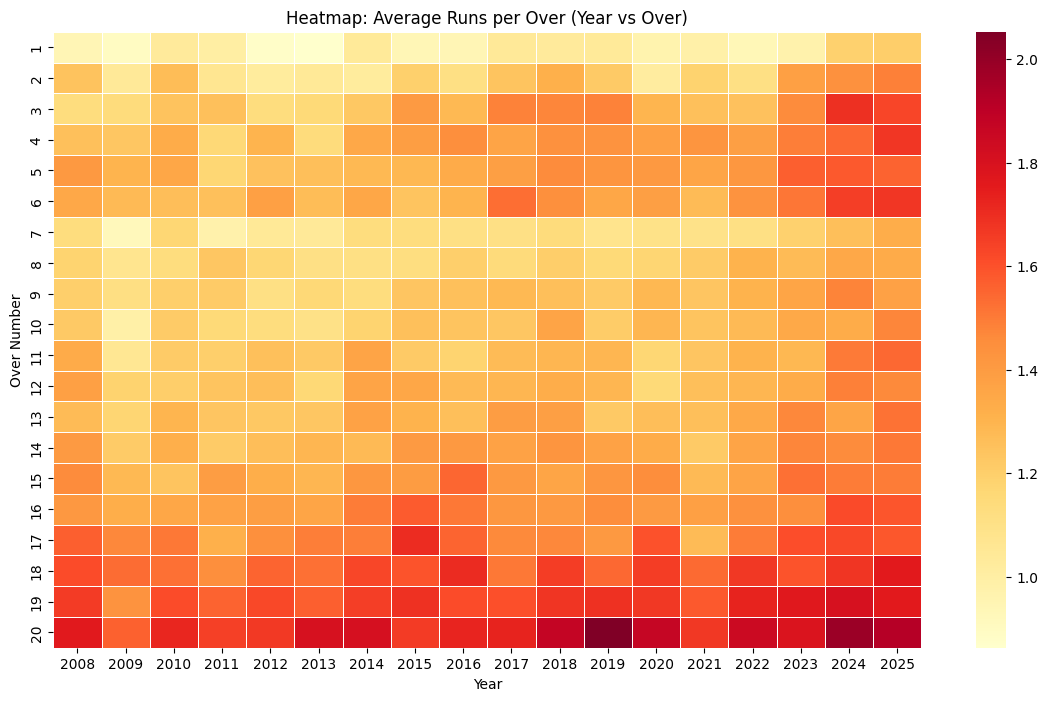

In [9]:
# Group by Year and Over
over_year_stats = df.groupby(['year', 'over'])['total_runs'].mean().reset_index()

# Pivot for Heatmap (Rows: Over, Cols: Year, Values: Avg Runs)
heatmap_data = over_year_stats.pivot(index='over', columns='year', values='total_runs')

plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_data, cmap='YlOrRd', annot=False, linewidths=.5)
plt.title('Heatmap: Average Runs per Over (Year vs Over)')
plt.ylabel('Over Number')
plt.xlabel('Year')
# Invert y-axis so Over 1 is at the top, Over 20 at the bottom (optional, but standard for lists)
# plt.gca().invert_yaxis() 
plt.show()

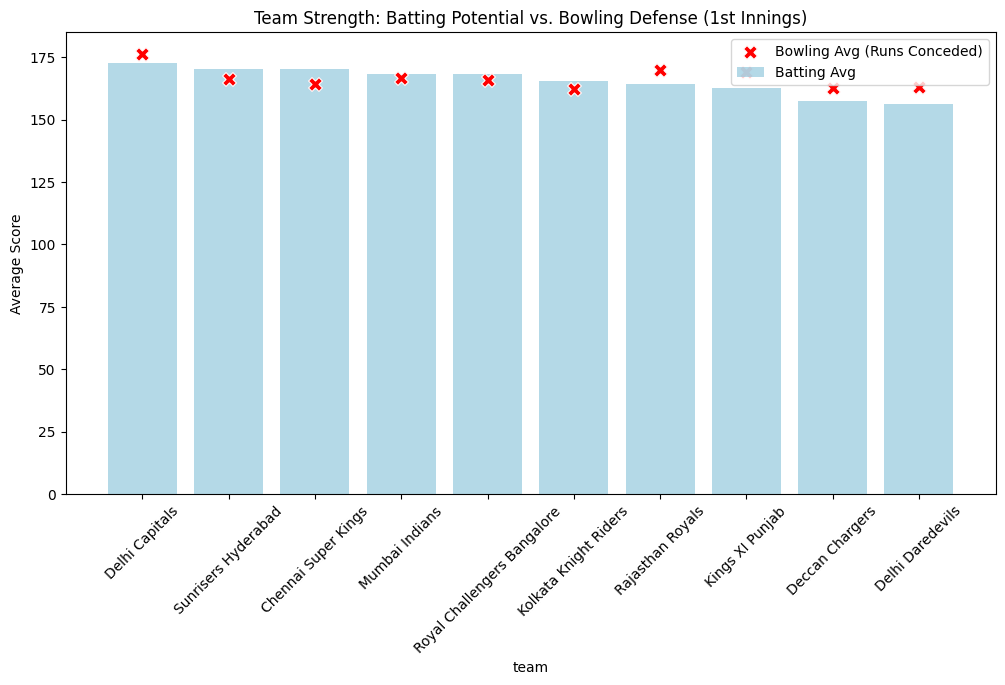

In [10]:
# 1. Calculate Average Score Batting First
batting_avg = match_df[match_df['innings'] == 1].groupby('batting_team')['final_score'].mean().reset_index()
batting_avg = batting_avg.rename(columns={'final_score': 'avg_batting_score'})

# 2. Calculate Average Score Conceded (Bowling Strength)
bowling_avg = match_df[match_df['innings'] == 1].groupby('bowling_team')['final_score'].mean().reset_index()
bowling_avg = bowling_avg.rename(columns={'final_score': 'avg_runs_conceded'})

# Merge and Filter for active teams (teams with > 50 matches)
team_stats = pd.merge(batting_avg, bowling_avg, left_on='batting_team', right_on='bowling_team')
team_stats = team_stats.drop(columns=['bowling_team']).rename(columns={'batting_team': 'team'})

# Filter for top 10 frequent teams
top_teams = df['batting_team'].value_counts().head(10).index
team_stats = team_stats[team_stats['team'].isin(top_teams)].sort_values('avg_batting_score', ascending=False)

# Plot
plt.figure(figsize=(12, 6))

# Batting Bar
sns.barplot(data=team_stats, x='team', y='avg_batting_score', color='skyblue', label='Batting Avg', alpha=0.7)
# Bowling Marker (Lines or Points)
sns.scatterplot(data=team_stats, x='team', y='avg_runs_conceded', color='red', s=100, marker='X', label='Bowling Avg (Runs Conceded)')

plt.title('Team Strength: Batting Potential vs. Bowling Defense (1st Innings)')
plt.ylabel('Average Score')
plt.xticks(rotation=45)
plt.legend()
plt.show()